In [15]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

from sklearn.preprocessing import MinMaxScaler

In [7]:
# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

In [8]:
from datetime import datetime

# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

# Run XGBoost first before running below, use if not have a matching input format validation

In [4]:
# Combine relevant columns into a single text column
with pd.read_csv("./temp/validation.csv", chunksize=chunksize) as reader:
    i = 0
    for chunk in reader:
        print ("----------------Processing chunk: ", i ,"-----------------------")
        processed_chunk = process_chunk(chunk)
        processed_data.append(processed_chunk)
        i += 1

print ("Finish text column generation, combining chunk....")
# Combine all processed chunks into a single DataFrame
processed_data = pd.concat(processed_data, ignore_index=True)
#     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
#     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
#     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
#     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
#     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
#     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

processed_data

----------------Processing chunk:  0 -----------------------
----------------Processing chunk:  1 -----------------------
----------------Processing chunk:  2 -----------------------
----------------Processing chunk:  3 -----------------------
----------------Processing chunk:  4 -----------------------
----------------Processing chunk:  5 -----------------------
----------------Processing chunk:  6 -----------------------
----------------Processing chunk:  7 -----------------------
----------------Processing chunk:  8 -----------------------
----------------Processing chunk:  9 -----------------------
----------------Processing chunk:  10 -----------------------
----------------Processing chunk:  11 -----------------------
----------------Processing chunk:  12 -----------------------
----------------Processing chunk:  13 -----------------------
----------------Processing chunk:  14 -----------------------
----------------Processing chunk:  15 -----------------------
----------------Pr

,text,encoded_label
0,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
1,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
2,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
3,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
4,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
...,...,...
16326932,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326933,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326934,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326935,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1


In [5]:
features = processed_data['text'].apply(split_string2)
processed_data['text'] = features
processed_data

,text,encoded_label
0,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
1,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
2,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
3,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
4,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
...,...,...
16326932,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326933,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326934,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326935,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1


In [6]:
# Check for NaN and infinite values
if processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
processed_data = new_df

In [7]:
processed_data

,text,encoded_label
0,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
1,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
2,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
3,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
4,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
...,...,...
16326932,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326933,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326934,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326935,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1


In [8]:
# We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
column_names = [f'feature_{i}' for i in range(0, 22)]

# Create a new DataFrame with separate columns
encoded_labels = processed_data["encoded_label"]
processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
processed_data_expanded.dropna(inplace=True)
processed_data_expanded["encoded_labels"] = encoded_labels

processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
1,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
2,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
3,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
4,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326932,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326933,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326934,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326935,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1


# If have a saved matching input format validation

In [9]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
processed_data_expanded = pd.read_csv('./temp/scaled_validation_one_col.csv')
# processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.630983,0.979582,0.002110,0.0,0.000000e+00,0.0,0.0,0.002113,0.000000e+00,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,0.029047,7.289669e-295,0.000019,1
1,0.630983,0.979582,0.002110,0.0,0.000000e+00,0.0,0.0,0.002113,0.000000e+00,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,0.029047,7.289669e-295,0.000019,1
2,0.630983,0.979582,0.002110,0.0,0.000000e+00,0.0,0.0,0.002113,0.000000e+00,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,0.029047,7.289669e-295,0.000019,1
3,0.630983,0.979582,0.002110,0.0,0.000000e+00,0.0,0.0,0.002113,0.000000e+00,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,0.029047,7.289669e-295,0.000019,1
4,0.630983,0.979582,0.002110,0.0,0.000000e+00,0.0,0.0,0.002113,0.000000e+00,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,0.029047,7.289669e-295,0.000019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737883,0.583069,0.611366,0.000025,0.0,0.000000e+00,0.0,0.0,0.000027,0.000000e+00,0.016706,...,0.270207,0.000017,0.004046,0.665012,0.030961,0.241181,0.094337,2.172119e-293,0.000032,1
1737884,0.583069,0.611366,0.000025,0.0,0.000000e+00,0.0,0.0,0.000027,0.000000e+00,0.016706,...,0.270207,0.000017,0.004046,0.665012,0.030961,0.241181,0.094337,2.172119e-293,0.000032,1
1737885,0.583069,0.611366,0.000025,0.0,0.000000e+00,0.0,0.0,0.000027,0.000000e+00,0.016706,...,0.270207,0.000017,0.004046,0.665012,0.030961,0.241181,0.094337,2.172119e-293,0.000032,1
1737886,0.583069,0.611366,0.000025,0.0,0.000000e+00,0.0,0.0,0.000027,0.000000e+00,0.016706,...,0.270207,0.000017,0.004046,0.665012,0.030961,0.241181,0.094337,2.172119e-293,0.000032,1


In [10]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X_val = processed_data_expanded.drop('encoded_labels', axis=1)
y_val = processed_data_expanded['encoded_labels']

# XGBoost

Since XGBoost can manually use adjust the scale of minority class, using non-oversampling/undersampling data is beneficial because it avoids duplicate data

In [11]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
train_processed_data = pd.read_csv('./temp/one_text_col_data.csv')

train_processed_data

,text,encoded_label
0,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",1
1,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",1
2,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",1
3,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",1
4,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",1
...,...,...
5915131,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",1
5915132,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",1
5915133,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",1
5915134,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",1


In [12]:
# one_text_col_data
features = train_processed_data['text'].apply(split_string2)
train_processed_data['text'] = features
train_processed_data

,text,encoded_label
0,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",1
1,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",1
2,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",1
3,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",1
4,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",1
...,...,...
5915131,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",1
5915132,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",1
5915133,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",1
5915134,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",1


In [16]:
# # Check for NaN and infinite values
# if train_processed_data.isnull().values.any():
#     print("There are NaN values in the processed_data dataframe")
    
# # Convert it to float32 for Random Forest library
# from sklearn.preprocessing import MinMaxScaler

# # Convert the "text" column to a numpy array
# text_array = np.array(list(train_processed_data["text"]))

# # Scale down the values in the array to the range [0, 1]
# scaler = MinMaxScaler()
# text_array_scaled = scaler.fit_transform(text_array)

# # Cast the scaled array to the float32 data type
# text_array_scaled = text_array_scaled.astype(np.float32)

# # Create a new dataframe with the scaled "text" column and the original "encoded_label" column
# new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': train_processed_data['encoded_label']})

# # Replace the original "processed_data" dataframe with the new dataframe
# train_processed_data = new_df



# Check for NaN and infinite values
if train_processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert list of lists in text column to DataFrame
text_df = pd.DataFrame(train_processed_data['text'].to_list())

# Replace infinite values with NaN
text_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN with a large number (for example, max float64)
text_df.fillna(np.finfo(np.float64).max, inplace=True)

# Scale values using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(text_df)

# Replace original text column with scaled values
train_processed_data['text'] = list(scaled_values)

E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [18]:
train_processed_data

,text,encoded_label
0,"[0.6234549535280092, 0.9976107871085054, 0.002...",1
1,"[0.6234549535280092, 0.9976107871085054, 0.002...",1
2,"[0.6234549535280092, 0.9976107871085054, 0.002...",1
3,"[0.6234549535280092, 0.9976107871085054, 0.002...",1
4,"[0.6234549535280092, 0.9976107871085054, 0.002...",1
...,...,...
5915131,"[0.35465242571638456, 0.9999752544213694, 0.02...",1
5915132,"[0.35465242571638456, 0.9999752544213694, 0.02...",1
5915133,"[0.35465242571638456, 0.9999752544213694, 0.02...",1
5915134,"[0.35465242571638456, 0.9999752544213694, 0.02...",1


In [20]:
# We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
train_column_names = [f'feature_{i}' for i in range(0, 22)]

# Create a new DataFrame with separate columns
train_encoded_labels = train_processed_data["encoded_label"]
train_processed_data_expanded = pd.DataFrame(train_processed_data['text'].tolist(), columns=train_column_names, index=train_processed_data.index)
train_processed_data_expanded.dropna(inplace=True)
train_processed_data_expanded["encoded_labels"] = train_encoded_labels

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
1,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
2,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
3,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
4,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915131,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.785258,0.000091,0.018721,0.680482,1.000000,0.465448,7.123401e-07,2.652135e-296,0.000009,1
5915132,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
5915133,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1
5915134,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,1


In [21]:
train_processed_data_expanded.to_csv("./temp/scaled_train_data.csv")

# If have saved train data

In [2]:
train_processed_data_expanded = pd.read_csv('./temp/scaled_train_data.csv')
# train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

train_processed_data_expanded

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
1,1,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
2,2,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
3,3,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
4,4,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,16333467,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333468,16333468,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333469,16333469,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333470,16333470,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1


In [22]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X = train_processed_data_expanded.drop('encoded_labels', axis=1)
y = train_processed_data_expanded['encoded_labels']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Calculate the scale_pos_weight if you haven't done it yet
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
scale_pos_weight

0.03212176665027204

In [24]:
import xgboost as xgb

clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight) # 0.99 means a more balanced dataset than scale_pos_weight
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
clf.save_model("./temp/xgb_model.bin") # _099

In [5]:
import xgboost as xgb

clf = xgb.XGBClassifier()
clf.load_model("./temp/xgb_model.bin") # _099

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Predict and evaluate the model
y_val_pred = clf.predict(X_val)
y_val_pred

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
from sklearn.metrics import roc_curve, auc

precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calculate the probabilities for the ROC AUC score
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Precision: 1.000
Recall: 0.998
F1-score: 0.999
ROC AUC: 0.989


In [27]:
print (classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     27549
           1       1.00      1.00      1.00   1710339

    accuracy                           1.00   1737888
   macro avg       0.95      0.99      0.97   1737888
weighted avg       1.00      1.00      1.00   1737888



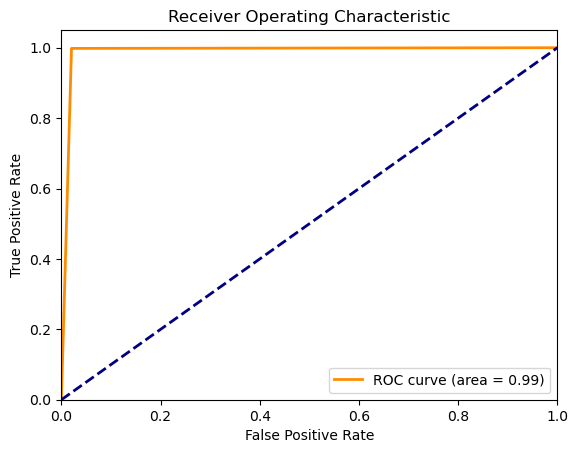

In [28]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('xgb.png')
plt.show()

In [20]:
# processed_data_expanded.to_csv("./output/scaled_validation_one_col.csv")
# train_processed_data_expanded.to_csv("./output/scaled_train_one_col.csv")

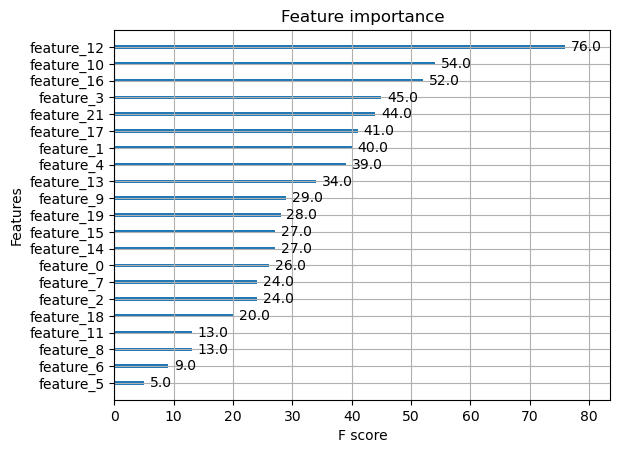

In [29]:
import matplotlib.pyplot as plt

# assuming that bst is your trained model
# e.g. bst = xgb.train(params, dtrain, num_rounds)
xgb.plot_importance(clf)
plt.show()

FScore

f12 : 76 Account Type --> address

f10: 54 mean_time_between_transactions --> address

f16: 52 StdDevBalance --> tag cluster

f3: 45 receipt_effective_gas_price_count --> address

f21: 44 MeanSentETHPerLifetime --> tag cluster

f17: 41 ClusterLifetime --> tag cluster

f1: 40 block_timestamp_min --> address

f4: 39 eth_balance_last --> address

In [19]:
# random_50k_balance_transactions = pd.read_csv('./data/Google_BigQuery/bq_50k_random_balance_transaction.csv')

# random_50k_balance_transactions.head(5)

C:\Users\vieth\AppData\Local\Temp\ipykernel_28788\1527264678.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  random_50k_balance_transactions = pd.read_csv('./data/Google_BigQuery/bq_50k_random_balance_transaction.csv')


,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,address,eth_balance
0,0x099b65808936130f10322474c0d07a19b1037b2a1d41...,392164,106,0x6cc8dcbca746a6e4fdefb98e1d0df903b107fd21,0xdac17f958d2ee523a2206206994597c13d831ec7,0,105209,30201557172,0xa9059cbb0000000000000000000000006c9ca8cf2bbc...,9104034,...,1.0,2023-03-30 23:47:59 UTC,16943420,0x44bd9dd7b8570fa5c9d7e0316f0c254ef02c174d6f4a...,6.273784e+10,94000000.0,2.0,30201557172,0x6cc8dcbca746a6e4fdefb98e1d0df903b107fd21,271884080089813097171
1,0x47753f8d169effaf760229029b5a4ffe565395ebe961...,95,88,0xa27ee6979b301aad6cc235802090a884656a9278,0xbc85294add408c5086f45b4f4603a3f3febccd71,2000000000000000000,21000,25020151358,0x,6553549,...,1.0,2023-03-31 00:12:11 UTC,16943539,0xddbd5e9f4db9242ff4fb30cd4e034e1055be45e045b0...,2.979026e+10,100000000.0,2.0,25020151358,0xbc85294add408c5086f45b4f4603a3f3febccd71,0
2,0xd48ab80f36535bb5ff35667e490bcf1b7c0521d48afe...,392163,117,0x6cc8dcbca746a6e4fdefb98e1d0df903b107fd21,0x0fc7b1e89139b6e0422816e037b4eed947278c29,50000000000000000,21000,27033577089,0x,15919565,...,1.0,2023-03-30 23:44:47 UTC,16943404,0x1083f6a2a98712beee036c0d215ae0035cf06ac0151d...,5.531754e+10,98472693.0,2.0,27033577089,0x6cc8dcbca746a6e4fdefb98e1d0df903b107fd21,271884080089813097171
3,0x47eee15264bebd52f67a5a719105fd1dfc8ec3aaddff...,2594,11,0xe6a7a1d47ff21b6321162aea7c6cb457d5476bca,0x83b72f566f6ef3fd4a25c58119809f846602292c,1926795470710522600,22000,59893661889,0x,252000,...,NaN,2015-08-16 07:52:28 UTC,94647,0xc2eb380fbd0868ed65ea0fc7c4265fb70f09af5e4f65...,NaN,NaN,NaN,59893661889,0x83b72f566f6ef3fd4a25c58119809f846602292c,0
4,0x64e63e0c5eacdd93e49768a541f39df8ed88ab99d556...,1560,12,0xe6a7a1d47ff21b6321162aea7c6cb457d5476bca,0x83b72f566f6ef3fd4a25c58119809f846602292c,2591114596029736000,22000,59586368840,0x,273000,...,NaN,2015-08-14 10:14:30 UTC,84264,0x300c51a6417a491c0c38b71ce8a5e23d0ca2d411ad92...,NaN,NaN,NaN,59586368840,0x83b72f566f6ef3fd4a25c58119809f846602292c,0


In [20]:
# random_50k_balance_transactions.describe()

,nonce,transaction_index,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_status,block_number,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
count,1.253803e+06,1.253803e+06,1.253803e+06,1.253803e+06,1.253803e+06,1.253803e+06,1.239148e+06,1.253803e+06,4.814960e+05,4.814960e+05,498735.000000,1.253803e+06
mean,3.497878e+05,1.325063e+02,8.376608e+04,6.455847e+10,8.825359e+06,4.758038e+04,9.883727e-01,1.205798e+07,9.853307e+10,9.047419e+09,1.935892,6.455847e+10
std,2.562403e+06,1.011384e+02,2.358083e+05,1.329069e+11,7.183264e+06,1.546421e+05,1.072015e-01,3.031231e+06,1.494099e+11,4.184449e+10,0.345086,1.329069e+11
min,0.000000e+00,0.000000e+00,2.100000e+04,0.000000e+00,1.431300e+04,1.344000e+04,0.000000e+00,4.731100e+04,2.000000e+09,0.000000e+00,0.000000,0.000000e+00
25%,5.000000e+00,5.700000e+01,2.100000e+04,1.200000e+10,3.277140e+06,2.100000e+04,1.000000e+00,9.974522e+06,2.325174e+10,1.000000e+09,2.000000,1.200000e+10
50%,1.195000e+03,1.150000e+02,6.077900e+04,3.700000e+10,7.079862e+06,2.392100e+04,1.000000e+00,1.240831e+07,5.609128e+10,1.418093e+09,2.000000,3.700000e+10
75%,1.328775e+05,1.830000e+02,9.389500e+04,9.653094e+10,1.213707e+07,5.194500e+04,1.000000e+00,1.434455e+07,1.372380e+11,3.556060e+09,2.000000,9.653094e+10
max,4.564684e+07,1.388000e+03,2.847195e+07,4.145025e+13,3.021777e+07,2.356618e+07,1.000000e+00,1.694354e+07,1.368705e+13,8.002000e+12,2.000000,4.145025e+13


In [21]:
# random_50k_balance_transactions.dtypes

hash                            object
nonce                            int64
transaction_index                int64
from_address                    object
to_address                      object
value                           object
gas                              int64
gas_price                        int64
input                           object
receipt_cumulative_gas_used      int64
receipt_gas_used                 int64
receipt_contract_address        object
receipt_root                    object
receipt_status                 float64
block_timestamp                 object
block_number                     int64
block_hash                      object
max_fee_per_gas                float64
max_priority_fee_per_gas       float64
transaction_type               float64
receipt_effective_gas_price      int64
address                         object
eth_balance                     object
dtype: object

In [22]:
# random_50k_balance_transactions['nonce'].dtypes == 'int64'

True

In [23]:
# random_50k_balance_transactions['hash'] = random_50k_balance_transactions['hash'].astype(str)
# random_50k_balance_transactions['from_address'] = random_50k_balance_transactions['from_address'].astype(str)
# random_50k_balance_transactions['to_address'] = random_50k_balance_transactions['to_address'].astype(str)
# random_50k_balance_transactions['value'] = random_50k_balance_transactions['value'].astype(str)
# random_50k_balance_transactions['input'] = random_50k_balance_transactions['input'].astype(str)
# random_50k_balance_transactions['receipt_contract_address'] = random_50k_balance_transactions['receipt_contract_address'].astype(str)
# random_50k_balance_transactions['receipt_root'] = random_50k_balance_transactions['receipt_root'].astype(str)
# random_50k_balance_transactions['block_hash'] = random_50k_balance_transactions['block_hash'].astype(str)
# random_50k_balance_transactions['eth_balance'] = random_50k_balance_transactions['eth_balance'].astype(str)

# random_50k_balance_transactions.dtypes

hash                            object
nonce                            int64
transaction_index                int64
from_address                    object
to_address                      object
value                           object
gas                              int64
gas_price                        int64
input                           object
receipt_cumulative_gas_used      int64
receipt_gas_used                 int64
receipt_contract_address        object
receipt_root                    object
receipt_status                 float64
block_timestamp                 object
block_number                     int64
block_hash                      object
max_fee_per_gas                float64
max_priority_fee_per_gas       float64
transaction_type               float64
receipt_effective_gas_price      int64
address                         object
eth_balance                     object
dtype: object

In [24]:
# from dateutil.parser import parse

# # convert block_timestamp to datetime format
# random_50k_balance_transactions['block_timestamp'] = random_50k_balance_transactions['block_timestamp'].apply(lambda x: parse(x))
# random_50k_balance_transactions

KeyboardInterrupt: 

In [ ]:
# # add a new column to calculate transaction amount in USD
# eth_usd_price = 1840  # the ETH/USD price at the time of this code
# df = random_50k_balance_transactions

# # convert value from wei to ETH
# df['value'] = pd.to_numeric(df['value'], errors='coerce') / 10**18
# df['eth_balance'] = pd.to_numeric(df['eth_balance'], errors='coerce')
# df['USD_value'] = df['value'] * eth_usd_price
# df

In [ ]:
# df['received_value'] = df.apply(lambda row: row['value'] if row['to_address'] == row['address'] else 0, axis=1)
# df['sent_value'] = df.apply(lambda row: row['value'] if row['from_address'] == row['address'] else 0, axis=1)

# # calculate number of withdrawals and deposits
# df['num_withdrawals'] = df.apply(lambda row: 1 if row['from_address'] == row['address'] else 0, axis=1)
# df['num_deposits'] = df.apply(lambda row: 1 if row['to_address'] == row['address'] else 0, axis=1)

# df

In [ ]:
# agg_dict = {
#     'value': ['sum'], 
#     'USD_value': ['sum'], 
#     'block_timestamp': ['min', 'max'], 
#     'receipt_status': ['count'],
#     'from_address': pd.Series.nunique, 
#     'to_address': pd.Series.nunique,
#     'eth_balance': ['last'],
#     'received_value': ['sum'],
#     'sent_value': ['sum'],
#     'num_withdrawals': ['sum'],
#     'num_deposits': ['sum']
# }
# grouped = df.groupby('address').agg(agg_dict)

# grouped

In [ ]:
# # flatten the column names after aggregation
# grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]

# grouped

In [ ]:
# # calculate highest received USD
# grouped['highest_transaction_USD'] = df.groupby('address')['USD_value'].max()


# grouped.describe()

In [ ]:
# # calculate mean time between transactions
# grouped['mean_time_between_transactions'] = (
#     grouped['block_timestamp_max'] - grouped['block_timestamp_min']) / grouped['receipt_status_count']
# grouped['mean_time_between_transactions'] = grouped['mean_time_between_transactions'].apply(lambda x: x.total_seconds())

# # calculate lifetime of each address
# grouped['lifetime'] = (grouped['block_timestamp_max'] - grouped['block_timestamp_min']).apply(lambda x: x.total_seconds())

# grouped

In [ ]:
# # rename the columns and reset index
# grouped = grouped.rename(columns={'eth_balance_last': 'latest_balance'})
# grouped = grouped.reset_index()

# grouped